# Import Libraries

In [1]:
import pandas as pd
import os
import tensorflow as tf
import re
import string
import numpy as np
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.models import Model
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import requests
import csv
from io import StringIO
from sklearn.utils import resample
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from rapidfuzz import process
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from custom_layers import TokenAndPositionEmbedding, TransformerBlock
from utils import data_loading, data_prep, balance_df, load_config

2025-06-09 22:14:30.988372: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749482071.002185    8363 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749482071.006165    8363 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749482071.018273    8363 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749482071.018299    8363 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749482071.018301    8363 computation_placer.cc:177] computation placer alr

In [2]:
config = load_config()

# Access hyperparameters
dataset_ver = config['dataset']['version']
maxlen = config['tokenizer']['maxlen']
vocab_size = config['tokenizer']['vocab_size']

num_transformer_blocks = config['model']['num_transformer_blocks']
embed_dim = config['model']['embed_dim']
num_heads = config['model']['num_heads']
ff_dim = config['model']['ff_dim']
dense_units = config['model']['dense_units']
num_classes = config['model']['num_classes']

dropout1_rate = config['dropout']['dropout1_rate']
dropout2_rate = config['dropout']['dropout2_rate']
dropout3_rate = config['dropout']['dropout3_rate']

root_path = ""
if dataset_ver == 2:
    root_path = "../data_preprocessing/dataset_preprocessed_v2"
else:
    root_path = "../data_preprocessing/dataset_preprocessed"

In [3]:
# List all CSV files in the folder
category_names = [f for f in os.listdir(root_path)]

print(category_names)

['Elektronik', 'Aksesoris', 'Kesehatan', 'Kecantikan', 'Alas_kaki', 'Pakaian_Pria', 'Pakaian_Wanita']


In [4]:
all_dfs = {
    name: data_loading(root_path, category)
    for name, category in zip(category_names, category_names)
}


Total combined rows of Elektronik: 4223

Total combined rows of Aksesoris: 5515

Total combined rows of Kesehatan: 783

Total combined rows of Kecantikan: 8654

Total combined rows of Alas_kaki: 3977

Total combined rows of Pakaian_Pria: 5699

Total combined rows of Pakaian_Wanita: 6411


# Data Preparation

### Checking the label distribution

In [5]:
for name, df in all_dfs.items():
    print(f"Category: {name}")
    print(df['label'].value_counts())

Category: Elektronik
label
positive    3169
neutral      993
negative      61
Name: count, dtype: int64
Category: Aksesoris
label
positive    3311
neutral     2112
negative      92
Name: count, dtype: int64
Category: Kesehatan
label
positive    528
neutral     233
negative     22
Name: count, dtype: int64
Category: Kecantikan
label
positive    4754
neutral     3642
negative     258
Name: count, dtype: int64
Category: Alas_kaki
label
positive    2472
neutral     1431
negative      74
Name: count, dtype: int64
Category: Pakaian_Pria
label
positive    3379
neutral     2139
negative     181
Name: count, dtype: int64
Category: Pakaian_Wanita
label
positive    3429
neutral     2585
negative     397
Name: count, dtype: int64


### Balancing DF

In [6]:
for name, df in all_dfs.items():
    print(f"Category: {name}")
    df = balance_df(df.dropna())
    all_dfs[name] = df

Category: Elektronik
Random multipliers: Class 0: 1.00, Class 1: 1.32, Class 2: 1.19
label
neutral     80
positive    72
negative    61
Name: count, dtype: int64
Category: Aksesoris
Random multipliers: Class 0: 1.39, Class 1: 1.12, Class 2: 1.28
label
positive    117
neutral     103
negative     92
Name: count, dtype: int64
Category: Kesehatan
Random multipliers: Class 0: 1.25, Class 1: 1.35, Class 2: 1.08
label
neutral     29
positive    23
negative    22
Name: count, dtype: int64
Category: Kecantikan
Random multipliers: Class 0: 1.45, Class 1: 1.21, Class 2: 1.11
label
neutral     312
positive    285
negative    258
Name: count, dtype: int64
Category: Alas_kaki
Random multipliers: Class 0: 1.11, Class 1: 1.50, Class 2: 1.48
label
neutral     110
positive    109
negative     74
Name: count, dtype: int64
Category: Pakaian_Pria
Random multipliers: Class 0: 1.28, Class 1: 1.14, Class 2: 1.04
label
neutral     206
positive    188
negative    181
Name: count, dtype: int64
Category: Pakaian

In [7]:
all_dfs['Kecantikan'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 855 entries, 0 to 854
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   rating       855 non-null    object
 1   date         855 non-null    object
 2   item_id      855 non-null    int64 
 3   parsed_date  855 non-null    object
 4   text_akhir   855 non-null    object
 5   label        855 non-null    object
dtypes: int64(1), object(5)
memory usage: 40.2+ KB


### Feature Selection

In [8]:
combined_df = pd.concat(all_dfs.values(), ignore_index=True)

combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3729 entries, 0 to 3728
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   rating       3729 non-null   object
 1   date         3729 non-null   object
 2   item_id      3729 non-null   int64 
 3   parsed_date  3729 non-null   object
 4   text_akhir   3729 non-null   object
 5   label        3729 non-null   object
dtypes: int64(1), object(5)
memory usage: 174.9+ KB


In [9]:
text_pad, tokenizer = data_prep(combined_df, vocab_size, maxlen)

In [10]:
print(text_pad)

[[341   0   0 ...   0   0   0]
 [454   0   0 ...   0   0   0]
 [  8 213 643 ...   0   0   0]
 ...
 [786 399   1 ...   0   0   0]
 [ 30   2   4 ...   0   0   0]
 [  2  11  14 ...   0   0   0]]


In [11]:
X = np.array(text_pad)

# Convert labels to integers
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(combined_df['label'])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
print(X_train.dtype, X_train.shape)
print(y_train.dtype, y_train.shape)

int32 (2983, 50)
int64 (2983,)


In [13]:
inputs = Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
x = Dropout(dropout1_rate)(x)  # NEW

# Multiple transformer blocks
for _ in range(1):
    x = TransformerBlock(embed_dim, num_heads, ff_dim)(x)

x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = Dropout(dropout2_rate)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = Dense(dense_units, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
x = Dropout(dropout3_rate)(x)
x = tf.keras.layers.BatchNormalization()(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)


I0000 00:00:1749482075.923829    8363 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2279 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [14]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_and_position_embedding    │ (None, 50, 64)         │       131,200 │
│ (TokenAndPositionEmbedding)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block               │ (None, 50, 64)         │        41,792 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 177,859 (694.76 KB)

 Trainable params: 177,603 (693.76 KB)

 Non-trainable params: 256 (1.00 KB)

In [15]:
from tensorflow.keras.callbacks import EarlyStopping

# Define EarlyStopping callback
early_stop = EarlyStopping(
    monitor='val_accuracy',  # Monitor validation accuracy
    patience=5,              # Stop after 5 epochs with no improvement
    restore_best_weights=True  # Restore the best model weights
)

# Train the model with EarlyStopping
model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=100,
    validation_data=(X_val, y_val),
    callbacks=[early_stop]
)

Epoch 1/100


I0000 00:00:1749482078.850767    9515 service.cc:152] XLA service 0x7f89c80074f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749482078.850786    9515 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2025-06-09 22:14:38.931285: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1749482079.305363    9515 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-06-09 22:14:40.895173: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_28', 80 bytes spill stores, 80 bytes spill loads

2025-06-09 22:14:40.977401: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_

34/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3209 - loss: 1.5822

I0000 00:00:1749482091.205032    9515 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


91/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3335 - loss: 1.5086

2025-06-09 22:14:53.254214: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_28', 400 bytes spill stores, 308 bytes spill loads

2025-06-09 22:14:54.006629: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_28', 532 bytes spill stores, 400 bytes spill loads

2025-06-09 22:14:54.057863: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_28', 80 bytes spill stores, 80 bytes spill loads

2025-06-09 22:14:54.267912: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_10', 352 bytes spill stores, 352 bytes spill loads

2025-06-09 22:14:54.456156: I external/loc

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.3340 - loss: 1.5058

2025-06-09 22:15:05.256611: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_9', 80 bytes spill stores, 80 bytes spill loads

2025-06-09 22:15:05.272183: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_9', 400 bytes spill stores, 308 bytes spill loads

2025-06-09 22:15:05.679475: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_9', 12 bytes spill stores, 12 bytes spill loads

2025-06-09 22:15:05.771891: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_9', 532 bytes spill stores, 400 bytes spill loads



94/94 ━━━━━━━━━━━━━━━━━━━━ 30s 166ms/step - accuracy: 0.3341 - loss: 1.5049 - val_accuracy: 0.3552 - val_loss: 1.2294
Epoch 2/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4011 - loss: 1.2222 - val_accuracy: 0.4718 - val_loss: 1.0173
Epoch 3/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5964 - loss: 0.8672 - val_accuracy: 0.8097 - val_loss: 0.4965
Epoch 4/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7916 - loss: 0.5341 - val_accuracy: 0.8190 - val_loss: 0.4500
Epoch 5/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8492 - loss: 0.4223 - val_accuracy: 0.8338 - val_loss: 0.5188
Epoch 6/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8763 - loss: 0.3691 - val_accuracy: 0.8244 - val_loss: 0.4945
Epoch 7/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8928 - loss: 0.3322 - val_accuracy: 0.7520 - val_loss: 0.7733
Epoch 8/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8999 - loss: 0.3137 - val_accuracy: 0.8298 - val_loss: 

### Testing

In [16]:
idx = 900

text_testing = combined_df['text_akhir'][idx]

text_testing

'terimakasih bonus emina'

In [19]:
# Convert to sequence using the same tokenizer
test_seq = tokenizer.texts_to_sequences([text_testing])

# Pad it to the same max length
test_pad = pad_sequences(test_seq, maxlen=maxlen, padding='post')

test_pad

array([[100, 172, 845,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]],
      dtype=int32)

In [20]:
prediction = model.predict(test_pad)

# Get class with highest probability
predicted_class = np.argmax(prediction, axis=1)[0]
print(f"Predicted label index: {predicted_class}")
print(f"Actual label: {combined_df['label'][idx]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted label index: 2
Actual label: positive


# Evaluation

In [21]:
# Predict class probabilities
y_pred_probs = model.predict(X_val)

# Get predicted class indices
y_pred = np.argmax(y_pred_probs, axis=1)

24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step


In [22]:
y_val_true = y_val  # Already encoded if you split after encoding
y_val_labels = label_encoder.inverse_transform(y_val_true)
y_pred_labels = label_encoder.inverse_transform(y_pred)

### Confusion Matrix

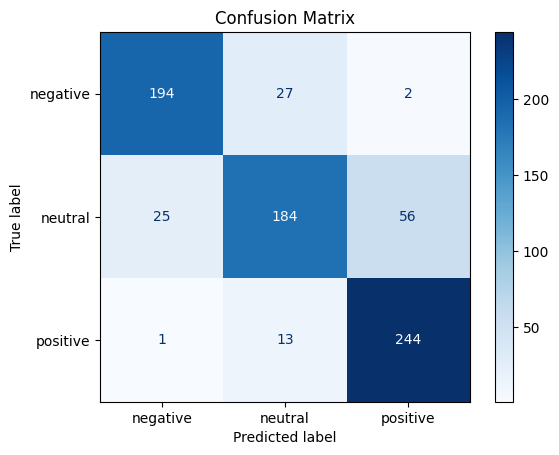

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# If using encoded labels
cm = confusion_matrix(y_val, y_pred)
labels = label_encoder.classes_  # Use class names if available

# Plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


### Classification Report

In [24]:
print(classification_report(y_val, y_pred, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

    negative       0.88      0.87      0.88       223
     neutral       0.82      0.69      0.75       265
    positive       0.81      0.95      0.87       258

    accuracy                           0.83       746
   macro avg       0.84      0.84      0.83       746
weighted avg       0.83      0.83      0.83       746



# Saving

In [ ]:
# Save the entire model to a file
model.save('sentiment_model.keras')